In [2]:
import re
import os
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
from nltk import FreqDist
from nltk.util import ngrams 
from zipfile import ZipFile
from kneebow.rotor import Rotor
from kneed import KneeLocator

Load 2 million word corpus

In [3]:
corpus = []

archive = ZipFile('corpus2mw.zip', 'r')

fileList = archive.namelist()
for file in fileList:
    corpus.append((archive.read(file)).decode('UTF-8'))


Process text (separate special characters from words)

In [4]:
regexp = re.compile('[\w \-]') 

def processText(corpus):
    corp = []
    for text in corpus:
        listT = list(text)
        i = 0
        for  c in listT:
            if (not regexp.search(c) and not listT[i-1]==' ') or not regexp.search(listT[i-1]) and regexp.search(c):
                listT.insert(i, ' ')
            i +=1
        corp.append(''.join(listT))
    return corp

readPickle = False
if readPickle:
    with open('corpusList', 'rb') as fp:
        corpus = pickle.load(fp)
else: 
    corpus =  processText(corpus)

    with open('corpusList', 'wb') as fp:
            pickle.dump(corpus, fp)

Compute ngrams

In [5]:
def compute_freq_doc(text, minG, maxG):
   freq_dist = FreqDist()
   if len(text) > 1:
       tokens = text.strip().split()
       for i in range(minG, maxG+1):
           grams = ngrams(tokens, i)
           freq_dist.update(grams)

   return dict(freq_dist)


def compute_freq_corpus(minG, maxG):
   freq_dist = FreqDist()
   for text in corpus:
        if len(text) > 1:
            tokens = text.strip().split()
            for i in range(minG, maxG+1):
                grams = ngrams(tokens, i)
                freq_dist.update(grams)

   return dict(freq_dist)


freq_dict = compute_freq_corpus(1, 8)
filtered_dict = {' '.join(key):val for key, val in freq_dict.items() if val > 1}

In [6]:
filtered_dict_sorted= sorted(filtered_dict.items(), key=lambda x: len(x[0].split()), reverse=True)
filtered_dict_sorted

[('" url = " http : / /', 4788),
 ('url = " http : / / en', 4788),
 ('= " http : / / en .', 4788),
 ('" http : / / en . wikipedia', 4788),
 ('http : / / en . wikipedia .', 4790),
 (': / / en . wikipedia . org', 4790),
 ('/ / en . wikipedia . org /', 4790),
 ('/ en . wikipedia . org / wiki', 4790),
 ('en . wikipedia . org / wiki ?', 4788),
 ('. wikipedia . org / wiki ? curid', 4788),
 ('wikipedia . org / wiki ? curid =', 4788),
 ('. Decadal growth in West Bengal was 17', 3),
 ('Decadal growth in West Bengal was 17 .', 3),
 ('growth in West Bengal was 17 . 84', 3),
 ('in West Bengal was 17 . 84 per', 3),
 ('West Bengal was 17 . 84 per cent', 3),
 ('Bengal was 17 . 84 per cent .', 3),
 ('is a village in the administrative district of', 40),
 ('a village in the administrative district of Gmina', 40),
 ('County , Łódź Voivodeship , in central Poland', 7),
 (', Łódź Voivodeship , in central Poland .', 7),
 ('Łódź Voivodeship , in central Poland . It', 6),
 ('Voivodeship , in central Poland .

In [48]:
expressions_count={}

for key, val in filtered_dict_sorted:
    expressions_count[key] = val

In [49]:
expressions_count


{'" url = " http : / /': 4788,
 'url = " http : / / en': 4788,
 '= " http : / / en .': 4788,
 '" http : / / en . wikipedia': 4788,
 'http : / / en . wikipedia .': 4790,
 ': / / en . wikipedia . org': 4790,
 '/ / en . wikipedia . org /': 4790,
 '/ en . wikipedia . org / wiki': 4790,
 'en . wikipedia . org / wiki ?': 4788,
 '. wikipedia . org / wiki ? curid': 4788,
 'wikipedia . org / wiki ? curid =': 4788,
 '. Decadal growth in West Bengal was 17': 3,
 'Decadal growth in West Bengal was 17 .': 3,
 'growth in West Bengal was 17 . 84': 3,
 'in West Bengal was 17 . 84 per': 3,
 'West Bengal was 17 . 84 per cent': 3,
 'Bengal was 17 . 84 per cent .': 3,
 'is a village in the administrative district of': 40,
 'a village in the administrative district of Gmina': 40,
 'County , Łódź Voivodeship , in central Poland': 7,
 ', Łódź Voivodeship , in central Poland .': 7,
 'Łódź Voivodeship , in central Poland . It': 6,
 'Voivodeship , in central Poland . It lies': 6,
 ', in central Poland . It lies

60833
61093
60935


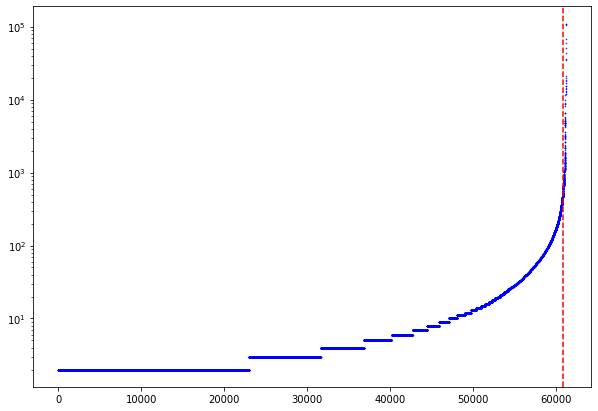

In [7]:
#unigrams
single_freq_dict = {key:val for key, val in filtered_dict.items() if len(key.split()) == 1}
#sort unigrams by value
single_freq_dict = {k: v for k, v in sorted(single_freq_dict.items(), key=lambda item: item[1])}


values = np.fromiter(single_freq_dict.values(), dtype=float)
stop_words_list = np.stack((np.arange(0, len(single_freq_dict)), values), axis = -1)
list_of_counts = list(single_freq_dict.items())


rotor = Rotor()
rotor.fit_rotate(stop_words_list)
elbow_idx = rotor.get_elbow_index()
print(elbow_idx)  
#rotor.plot_elbow()

kn = KneeLocator(stop_words_list[:,0] ,stop_words_list[:,1], curve='convex', direction='increasing')
print(int(kn.knee))

stop = 0
deltaX = 200
for idx, i, j in zip(range(0, len(values)), values, values[deltaX:]):
    if((j-i)>stop): stop = idx
print(stop)


fig = plt.figure()
ax = plt.gca()
ax.scatter(stop_words_list[:,0] ,stop_words_list[:,1] , s=1,c='blue', marker='.')
ax.set_yscale('log')
#ax.set_xscale('log')
fig.set_size_inches(10, 7)
plt.axvline(x=elbow_idx, color='r', linestyle='--')


relev_exp_unigrams = list_of_counts[:elbow_idx] #not really necessary
stop_words_unigrams = list_of_counts[elbow_idx:]

#TODO filter relevant expression dictionary if w1 or wn in stop_words_unigrams -> delete

In [31]:
stop_words=[]

for key, val in stop_words_unigrams:
    stop_words.append(key)

In [32]:
stop_words

['English',
 'major',
 'five',
 'those',
 'When',
 'death',
 'final',
 'French',
 'said',
 'often',
 'published',
 '—',
 'another',
 'within',
 'public',
 'last',
 'History',
 'died',
 'served',
 'large',
 '18',
 'village',
 'left',
 'children',
 'set',
 'District',
 'still',
 'day',
 'line',
 '12',
 'like',
 'if',
 'show',
 'February',
 'world',
 'due',
 'built',
 'During',
 'U',
 'own',
 'local',
 'St',
 'members',
 'high',
 'company',
 'small',
 'century',
 'include',
 'For',
 'North',
 '9',
 'single',
 'State',
 'very',
 'station',
 'former',
 'because',
 'back',
 'City',
 'member',
 'based',
 '2013',
 'took',
 'along',
 '2006',
 'received',
 'December',
 'November',
 'place',
 'home',
 'song',
 'League',
 'could',
 'government',
 '8',
 'did',
 'career',
 'around',
 'held',
 'town',
 'music',
 '2007',
 'age',
 'system',
 '2012',
 'British',
 'South',
 'named',
 '0',
 'April',
 'so',
 'However',
 'January',
 'located',
 'October',
 'end',
 'game',
 'York',
 'June',
 'March',
 'July'

In [9]:
def dice(freq, pref_freqs, suff_freqs):
    pref_freqs = list(pref_freqs)
    suff_freqs = list(suff_freqs)
    return 2 * freq / (sum(pref_freqs) / len(pref_freqs) + sum(suff_freqs) / len(suff_freqs))


def scp(freq, pref_freqs, suff_freqs):
    multiplied_freqs = [pref_freq * suff_freq for pref_freq, suff_freq in zip(pref_freqs, suff_freqs)]
    return freq ** 2 * len(multiplied_freqs) / sum(multiplied_freqs)

In [66]:
poss_re={}

idx=0
for key, val in filtered_dict_sorted:
    words= key.split()
    #print(words[-1])
    n= len(words)
    #print(n)
    if len(words) > 2:    
        ownpref=''
        ownsuf=''
        for i in range(0,n):
            if i==0:
                ownpref += key.split(' ')[i]
            elif i==n-1:
                ownsuf += key.split(' ')[i]
            else:
                ownpref += ' ' + key.split(' ')[i]
                ownsuf += key.split(' ')[i] + ' '
        xpref= expressions_count[ownpref]
        xsuf= expressions_count[ownsuf]
        gluew= val**2 /(xpref * xsuf)

        poss_re[key] = {'n':n,  'freq': val, 'glue': gluew, 'xpref': ownpref, 'xsuf': ownsuf}
        
    
#x = best glue from n-1 words


In [67]:
poss_re

{'" url = " http : / /': {'n': 8,
  'freq': 4788,
  'glue': 1.0,
  'xpref': '" url = " http : /',
  'xsuf': 'url = " http : / /'},
 'url = " http : / / en': {'n': 8,
  'freq': 4788,
  'glue': 1.0,
  'xpref': 'url = " http : / /',
  'xsuf': '= " http : / / en'},
 '= " http : / / en .': {'n': 8,
  'freq': 4788,
  'glue': 1.0,
  'xpref': '= " http : / / en',
  'xsuf': '" http : / / en .'},
 '" http : / / en . wikipedia': {'n': 8,
  'freq': 4788,
  'glue': 0.9995824634655532,
  'xpref': '" http : / / en .',
  'xsuf': 'http : / / en . wikipedia'},
 'http : / / en . wikipedia .': {'n': 8,
  'freq': 4790,
  'glue': 1.0,
  'xpref': 'http : / / en . wikipedia',
  'xsuf': ': / / en . wikipedia .'},
 ': / / en . wikipedia . org': {'n': 8,
  'freq': 4790,
  'glue': 1.0,
  'xpref': ': / / en . wikipedia .',
  'xsuf': '/ / en . wikipedia . org'},
 '/ / en . wikipedia . org /': {'n': 8,
  'freq': 4790,
  'glue': 1.0,
  'xpref': '/ / en . wikipedia . org',
  'xsuf': '/ en . wikipedia . org /'},
 '/ en

In [81]:
relevant_expressions={}
res=[]

for key, val in poss_re.items():
    if val['n'] in range(3,7):
        words = key.split()
        if words[0] in stop_words:
            continue
        if words[-1] in stop_words:
            continue
        if val['freq'] <= 2:
            continue
        
        try:
            xpref = poss_re[val['xpref']]['glue']
            xsuf = poss_re[val['xsuf']]['glue']
            bestx = max(xpref, xsuf)
        except:
            continue
        
        besty=1    
        for keyy, valy in poss_re.items():
            if key in keyy and valy['n'] == val['n']+1:
                if valy['glue']<besty:
                    besty=valy['glue']
                
        #print(bestx, besty)
        if val['glue']> (bestx+besty)/2:
            relevant_expressions[key]={'n':val['n'], 'freq': val['freq'], 'glue': val['glue']}
            res.append(key)
        

In [82]:
res

['Rural District , in the Central',
 'Iran . At the 2006 census',
 'inducted into the College Football Hall',
 'Arctiidae family . It was described',
 'Hispanic or Latino of any race',
 'Carniola . It is now included',
 'br > References . < br',
 '[ http : / / www',
 'According to the United States Census',
 '65 years of age or older',
 'households were made up of individuals',
 'Greater Poland Voivodeship , in west-central',
 'roles . The film had musical',
 'female householder with no husband present',
 "People ' s Republic of China",
 'Warmian-Masurian Voivodeship , in northern Poland',
 'included in the Southeast Slovenia statistical',
 'US Airways and US Airways Express',
 'male householder with no wife present',
 "awarded the Knight ' s Cross",
 'George H . W . Bush',
 'USA . The station is currently',
 "Iowa State didn ' t receive",
 'coaches poll which had them ranked',
 'Serbia . According to the 2002',
 'Algeria . According to the 1998',
 'climate in this area is characterize

In [ ]:
""" relev_expressions={ }


for key, value in filtered_dict.items():
    n= len(key.split(' '))
    if n>3:
        own_freq = value/(len(corpus)-n)
        #print(key)
        ownpref=''
        ownsuf=''
        for i in range(0,n):
            if i==0:
                ownpref += key.split(' ')[i]
            elif i==n-1:
                ownsuf += key.split(' ')[i]
            else:
                ownpref += ' ' + key.split(' ')[i]
                ownsuf += key.split(' ')[i] + ' '
        #print(ownpref)
        #print(ownsuf)
        own_pref_freq= filtered_dict[ownpref]/(len(corpus)-(n-1))
        own_suff_freq= filtered_dict[ownsuf]/(len(corpus)-(n-1))
        gluew= own_freq**2 /(own_pref_freq * own_suff_freq)
        #print(gluew)

        if own_pref_freq>own_suff_freq:
            aux= ownpref
            auxfreqy= own_pref_freq
        else:
            aux= ownsuf
            auxfreqy= own_suff_freq
            
        prefs=''
        sufs=''
        for i in aux.split(' ')[:-1]:
            prefs+=i+' '
        for i in aux.split(' ')[1:]:
            sufs+=i+' '
        
        own_pref_freq= filtered_dict[prefs.strip()]/(len(corpus)-(n-2))
        own_suff_freq= filtered_dict[sufs.strip()]/(len(corpus)-(n-2)) 
       
        gluex= auxfreqy**2 /(own_pref_freq * own_suff_freq)
        #print('x', gluex)
        
        besty=''
        bestfreqy=0
        for cha in filtered_dict.keys():
            if key.split(' ')[:]==(cha.split(' ')[:-1] or cha.split(' ')[1:]):
                #print(key, cha)
                wy= filtered_dict[cha]/(len(corpus)-(n+1))
                if wy>bestfreqy:
                    bestfreqy=wy
                    besty=cha
                          
        if(bestfreqy>0):
            pref=''
            suf=''
            for i in besty.split(' ')[:-1]:
                pref+=i+' '
            for i in besty.split(' ')[1:]:
                suf+=i+' '  
                        
            own_pref_freq= filtered_dict[pref.strip()]/(len(corpus)-(n-2))
            own_suff_freq= filtered_dict[suf.strip()]/(len(corpus)-(n-2)) 
        
            gluey= bestfreqy**2 /(own_pref_freq * own_suff_freq)
            
            re= (gluex+gluey)/2
            #print('re', re)
            #print('gluew', gluew)
            if re<gluew:
                relev_expressions[key]=re
                print(key)
        else:
            continue
    
         """
        
        
    

Stop Words

Explicit and Implicit Keywords

In [ ]:
def count_RE_in_doc(RE):
    count = 0
    for text in corpus:
        if RE in text:
            count += 1
    
    return count

def freq(RE,doc):
    freq_dict = compute_freq_doc(doc, len(RE.split()), len(RE.split()))
    
    return freq_dict[RE]


def tf_idf(RE, doc_idx):
    doc = corpus(idx)
    
    freq_RE = freq(RE,doc)
    
    return (freq_RE/len(doc))*math.log(len(corpus)/count_RE_in_doc(RE))

def calc_prob(word):
    sum_p = 0
    for doc in corpus:
        sum_p += freq(word, doc)/len(doc.split())
    return (1/len(corpus))*sum_p

def calc_cov(A,B):
    probA = calc_prob(A)
    probB = calc_prob(B)
    sum_p = 0
    for doc in corpus:
        sum_p += (freq(A, doc)/len(doc.split())-probA)*(freq(B, doc)/len(doc.split())-probB)
    return (1/len(corpus)-1)*sum_p

def correlation(A,B):
    return calc_cov(A, B)/(math.sqrt(calc_cov(A, A))*(math.sqrt(calc_cov(B, B))))


  
def IP(A,B):
    count = 0
    sum_dist = 0 
    for doc in corpus:
        if A in doc and B in doc:
            count += 1
            
        
        #TODO sum_dist += calculate closest divided by farthest distances between A and B
        
    
    return 1-(1/count)*sum_dist
        
       
def sem_prox(A,B):
    return correlation(A, B)*math.sqrt(IP(A,B))

def score_implicit(RE,doc):
    return #TODO